In [1]:
import pandas as pd
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm

%matplotlib inline

D:\Dev\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
commits = pd.read_pickle("../commits.pkl")

In [10]:
pattern = re.compile("Signed-off-by: (.*) <.*>")
review_pattern = re.compile("Reviewed-by: (.*) <.*>")

In [48]:
def isAMD(f):
    return "drivers/gpu/drm/radeon/" in f or "include/uapi/drm/radeon_drm.h" in f or "drivers/gpu/drm/amd/" in f or "include/uapi/drm/amdgpu_drm.h" in f

In [49]:
amd = commits[commits.files.map(isAMD)]

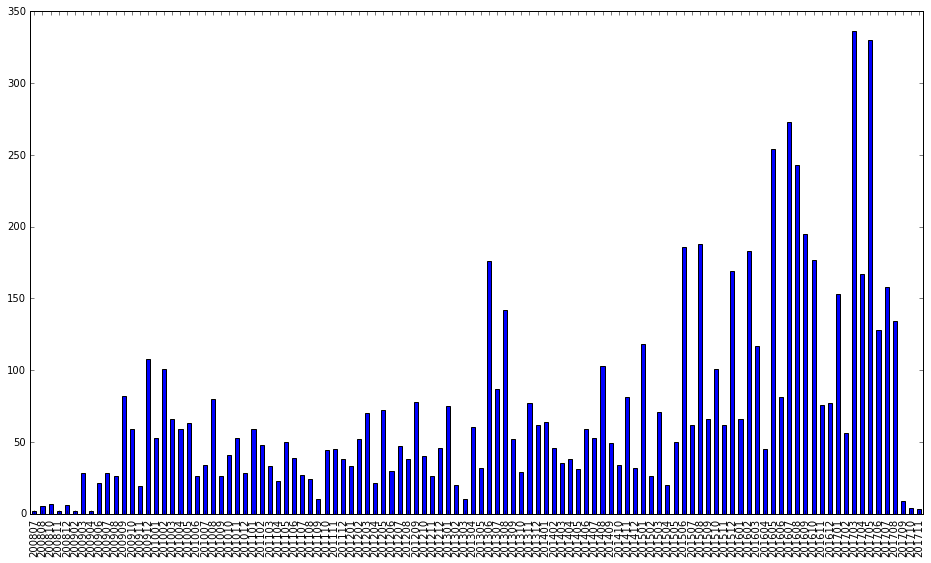

In [50]:
amd.committed_datetime.map(lambda t: t.year*100+t.month).value_counts().sort_index().plot('bar', figsize=(16,9), color='blue')

# throughput

In [51]:
result = {}
log = {}
for year in range(2013, 2018):
    for month in range(1, 13):
        if year == 2017 and month == 7:
            break
        selected = amd[amd.committed_datetime.map(lambda t: t.year == year and t.month == month)]
        counter = Counter()
        if (year,month) < (2015,10):
            for msg in selected.message:
                signers = pattern.findall(msg)
                if len(signers) > 1:
                    for signer in signers[1:]:
                        counter[signer] += 1
        else:
            for index in selected.index:
                row = selected.loc[index]
                author = row.author_name
                committer = row.committer_name
                msg = row.message
                if author == committer:
                    reviewers = review_pattern.findall(msg)
                    for reviewer in reviewers:
                        counter[reviewer] += 1
                else:
                    signers = pattern.findall(msg)
                    if len(signers) > 1:
                        for signer in signers[1:]:
                            counter[signer] += 1

        sorted_count = pd.Series(map(lambda t: t[1], counter.most_common()))
        log[(year,month)] = sorted_count
        result[(year, month)] = (sorted_count[:2].sum(), sorted_count[:2].sum() * 1.0 / sorted_count.sum(), sorted_count.sum())
        

In [52]:
stat = pd.DataFrame(result, index=['top2_count', 'top2_ratio', 'total']).T
stat.to_pickle('amd_throughput.pkl')

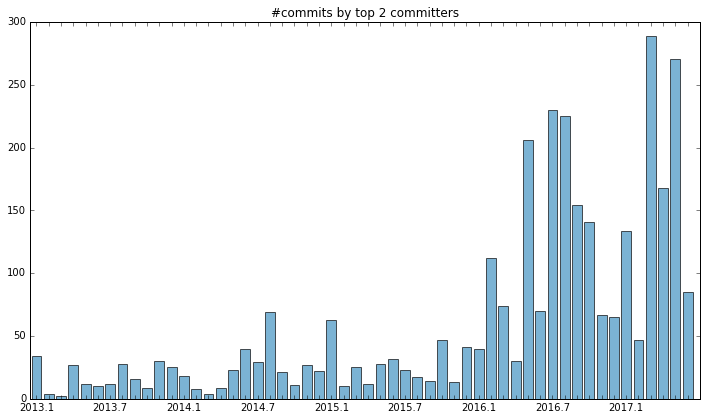

In [53]:
#stat['top2_count'].plot('bar', color='blue', figsize=(16,9)) # top 2 signers count

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(range(len(stat['top2_count'])), stat['top2_count'], color="#348ABD", alpha=0.65,
            label="#commits by top 2 committers", align="center")
#plt.ylim([75,110])
plt.xticks(range(len(stat['top2_count'])), stat['top2_count'].index.map(lambda t: str(t[0]) + "." + str(t[1]) if t[1] % 6 == 1 else ""))
plt.xlim([-0.5, len(stat['top2_count'])])
plt.title("#commits by top 2 committers")
plt.show()

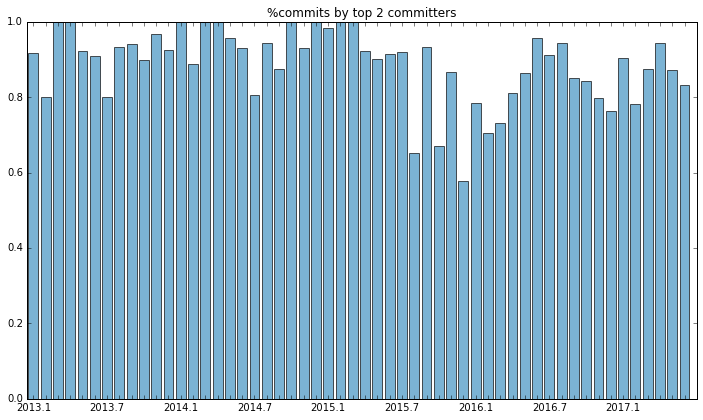

In [54]:

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(range(len(stat['top2_ratio'])), stat['top2_ratio'], color="#348ABD", alpha=0.65,
            label="#commits by top 2 committers", align="center")
#plt.ylim([75,110])
plt.xticks(range(len(stat['top2_ratio'])), stat['top2_ratio'].index.map(lambda t: str(t[0]) + "." + str(t[1]) if t[1] % 6 == 1 else ""))
plt.xlim([-0.5, len(stat['top2_ratio'])])
plt.title("%commits by top 2 committers")
plt.show()

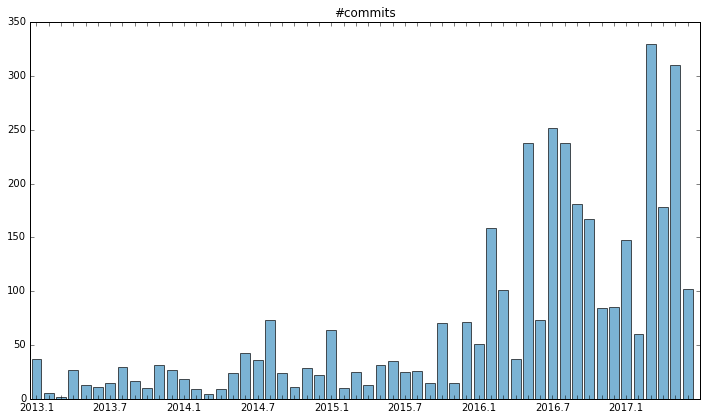

In [55]:
#stat['top2_count'].plot('bar', color='blue', figsize=(16,9)) # top 2 signers count

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(range(len(stat['total'])), stat['total'], color="#348ABD", alpha=0.65,
            label="#commits", align="center")
#plt.ylim([75,110])
plt.xticks(range(len(stat['total'])), stat['total'].index.map(lambda t: str(t[0]) + "." + str(t[1]) if t[1] % 6 == 1 else ""))
plt.xlim([-0.5, len(stat['total'])])
plt.title("#commits")
plt.show()

# latency

In [57]:
result = {}
for year in range(2013,2018):
    for month in range(1,13):
        if year == 2017 and month > 6:
            break
        subset = amd[amd.committed_datetime.map(lambda t: t.year * 1000 + t.month) == (year * 1000 + month)]
        desc = (subset.committed_datetime - subset.authored_datetime).describe()
        result[(year,month)] = desc

In [58]:
latency = pd.DataFrame(result).T
latency.to_pickle("amd_latency.pkl")
stat = latency

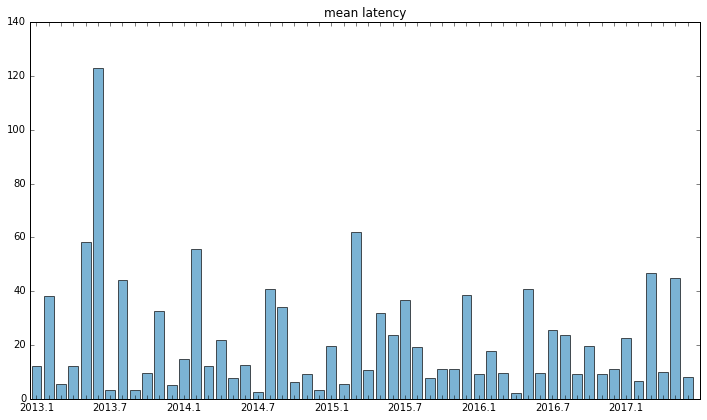

In [59]:
#stat['top2_count'].plot('bar', color='blue', figsize=(16,9)) # top 2 signers count

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(range(len(stat['mean'])), stat['mean'].map(lambda t: t.delta / (86400*1e9)), color="#348ABD", alpha=0.65,
            label="#commits", align="center")
#plt.ylim([75,110])
plt.xticks(range(len(stat['mean'])), stat['mean'].index.map(lambda t: str(t[0]) + "." + str(t[1]) if t[1] % 6 == 1 else ""))
plt.xlim([-0.5, len(stat['mean'])])
plt.title("mean latency")
plt.show()

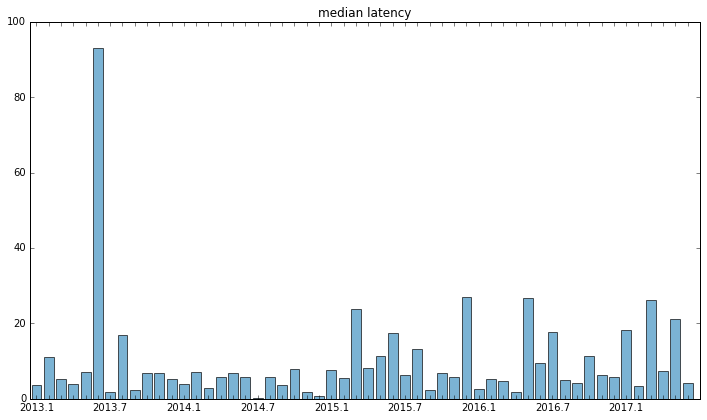

In [60]:
#stat['top2_count'].plot('bar', color='blue', figsize=(16,9)) # top 2 signers count

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(range(len(stat['50%'])), stat['50%'].map(lambda t: t.delta / (86400*1e9)), color="#348ABD", alpha=0.65,
            label="#commits", align="center")
#plt.ylim([75,110])
plt.xticks(range(len(stat['50%'])), stat['50%'].index.map(lambda t: str(t[0]) + "." + str(t[1]) if t[1] % 6 == 1 else ""))
plt.xlim([-0.5, len(stat['50%'])])
plt.title("median latency")
plt.show()

# pressure

In [62]:
result = {}
for year in range(2013,2018):
    for month in range(1,13):
        subset = amd[amd.committed_datetime.map(lambda t: t.year * 1000 + t.month) == (year * 1000 + month)]
        if year == 2017 and month > 6:
            break
        committers = subset.committer_name.value_counts(normalize=True)
        acc = 0.0
        for committer in committers.index:
            df = subset[subset.committer_name == committer]
            s = df.committed_datetime.map(lambda t: t.hour).value_counts(normalize=True)
            if len(s) > 8:
                acc += s[8:].sum() * committers[committer]
        result[(year,month)] = acc

In [63]:
pressure = pd.Series(result)
pressure.to_pickle('amd_pressure.pkl')

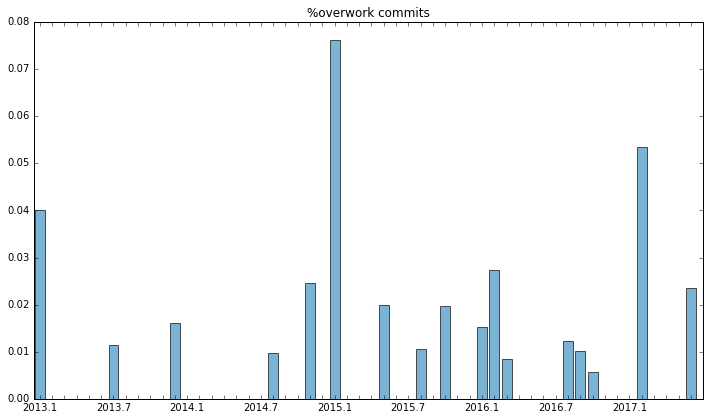

In [64]:
#stat['top2_count'].plot('bar', color='blue', figsize=(16,9)) # top 2 signers count

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(range(len(pressure)), pressure, color="#348ABD", alpha=0.65,
            label="#commits", align="center")
#plt.ylim([75,110])
plt.xticks(range(len(pressure)), pressure.index.map(lambda t: str(t[0]) + "." + str(t[1]) if t[1] % 6 == 1 else ""))
plt.xlim([-0.5, len(pressure)])
plt.title("%overwork commits")
plt.show()

In [65]:
def overwork_ratio(s):
    temp = {}
    for i in range(24):
        if i in s:
            temp[i] = s[i]
        else:
            temp[i] = 0
    for i in range(24, 48):
        temp[i] = temp[i-24]
    s = pd.Series(temp).sort_index()
    return 1 - s.rolling(window=8).sum().max()

#contiguous version
result = {}
for year in range(2013,2018):
    for month in range(1,13):
        subset = amd[amd.committed_datetime.map(lambda t: t.year * 1000 + t.month) == (year * 1000 + month)]
        if year == 2017 and month > 6:
            break
        committers = subset.committer_name.value_counts(normalize=True)
        acc = 0.0
        for committer in committers.index:
            df = subset[subset.committer_name == committer]
            s = df.committed_datetime.map(lambda t: t.hour).value_counts(normalize=True)
            ratio = overwork_ratio(s)
            acc += ratio * committers[committer]
        result[(year,month)] = acc

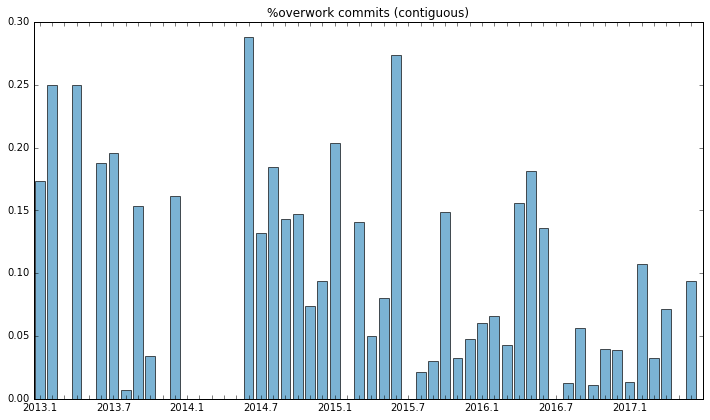

In [66]:
#stat['top2_count'].plot('bar', color='blue', figsize=(16,9)) # top 2 signers count
pressure = pd.Series(result)
plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(range(len(pressure)), pressure, color="#348ABD", alpha=0.65,
            label="%overwork commits", align="center")
plt.ylim([0.0,0.30])
plt.xticks(range(len(pressure)), pressure.index.map(lambda t: str(t[0]) + "." + str(t[1]) if t[1] % 6 == 1 else ""))
plt.xlim([-0.5, len(pressure)])
plt.title("%overwork commits (contiguous)")
plt.show()

In [67]:
pressure.to_pickle('amd_pressure_contiguous.pkl')

# complexity - file count

In [69]:
result = {}
log = {}
for year in range(2013, 2018):
    for month in range(1, 13):
        if year == 2017 and month == 6:
            break
        selected = amd[amd.committed_datetime.map(lambda t: t.year == year and t.month == month)]
        dev_to_prev = defaultdict(lambda: set())
        if (year,month) < (2015,10):
            for index in selected.index:
                row = selected.loc[index]
                msg = row.message
                files = row.files
                if len(files) > 65:
                    continue
                signers = pattern.findall(msg)
                for i in range(1, len(signers)):
                    dev_to_prev[signers[i]].add(signers[i-1])

        else:
            for index in selected.index:
                row = selected.loc[index]
                author = row.author_name
                committer = row.committer_name
                msg = row.message
                files = row.files
                if len(files) > 65:
                    continue
                if author == committer:
                    reviewers = review_pattern.findall(msg)
                    for reviewer in reviewers:
                        dev_to_prev[reviewer].add(author)
                else:
                    signers = pattern.findall(msg)
                    for i in range(1, len(signers)):
                        dev_to_prev[signers[i]].add(signers[i-1])
        
        counts = map(lambda s: len(s), dev_to_prev.values())
        log[(year,month)] = dev_to_prev
        result[(year, month)] = pd.Series(counts).describe()
        

In [70]:
pd.DataFrame(result).T.to_pickle('amd_author.pickle')
stat = pd.DataFrame(result).T

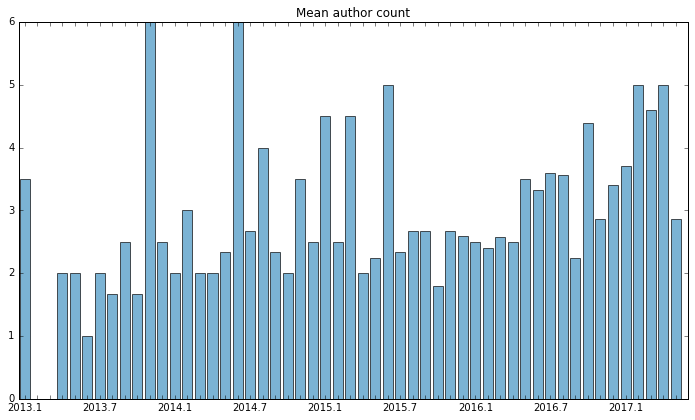

In [71]:
plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(range(len(stat['mean'])), stat['mean'], color="#348ABD", alpha=0.65,
            label="#commits", align="center")
#plt.ylim([75,110])
plt.xticks(range(len(stat['mean'])), stat['mean'].index.map(lambda t: str(t[0]) + "." + str(t[1]) if t[1] % 6 == 1 else ""))
plt.xlim([-0.5, len(stat['mean'])])
plt.title("Mean author count")
plt.show()

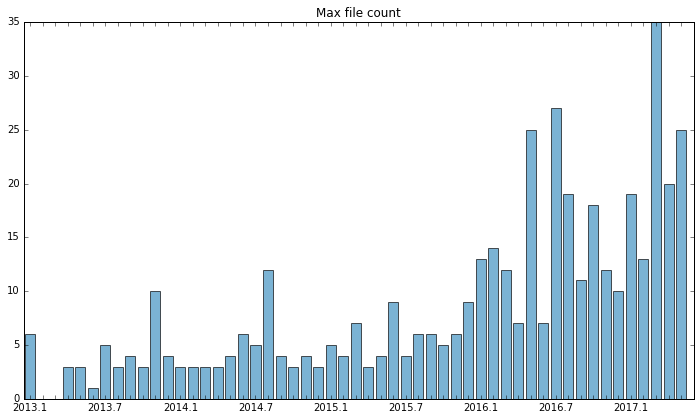

In [72]:
#pd.DataFrame(result).T['max'].plot('bar', color='blue',figsize=(16,9))

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(range(len(stat['max'])), stat['max'], color="#348ABD", alpha=0.65,
            label="#commits", align="center")
#plt.ylim([75,110])
plt.xticks(range(len(stat['max'])), stat['max'].index.map(lambda t: str(t[0]) + "." + str(t[1]) if t[1] % 6 == 1 else ""))
plt.xlim([-0.5, len(stat['max'])])
plt.title("Max file count")
plt.show()

# complexity - author count

In [75]:
result = {}
log = {}
for year in range(2013, 2018):
    for month in range(1, 13):
        if year == 2017 and month == 6:
            break
        selected = amd[amd.committed_datetime.map(lambda t: t.year == year and t.month == month)]
        dev_to_prev = defaultdict(lambda: set())
        if (year,month) < (2015,10):
            for index in selected.index:
                row = selected.loc[index]
                msg = row.message
                files = row.files
                if len(files) > 65:
                    continue
                signers = pattern.findall(msg)
                for i in range(1, len(signers)):
                    dev_to_prev[signers[i]].add(signers[i-1])

        else:
            for index in selected.index:
                row = selected.loc[index]
                author = row.author_name
                committer = row.committer_name
                msg = row.message
                files = row.files
                if len(files) > 65:
                    continue
                if author == committer:
                    reviewers = review_pattern.findall(msg)
                    for reviewer in reviewers:
                        dev_to_prev[reviewer].add(author)
                else:
                    signers = pattern.findall(msg)
                    for i in range(1, len(signers)):
                        dev_to_prev[signers[i]].add(signers[i-1])
        
        counts = map(lambda s: len(s), dev_to_prev.values())
        log[(year,month)] = dev_to_prev
        result[(year, month)] = pd.Series(counts).describe()
        

In [76]:
pd.DataFrame(result).T.to_pickle('amd_author.pickle')
stat = pd.DataFrame(result).T

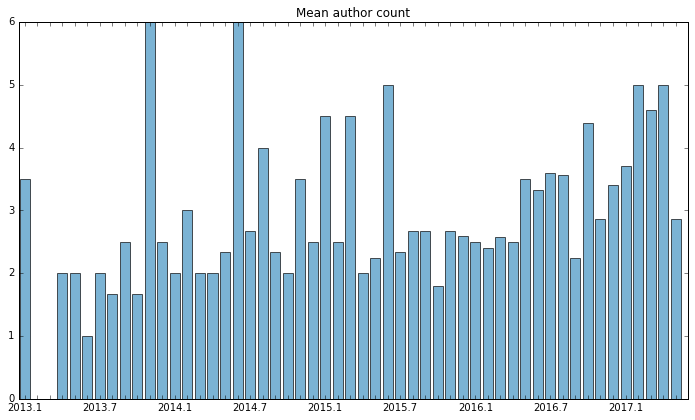

In [77]:
plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(range(len(stat['mean'])), stat['mean'], color="#348ABD", alpha=0.65,
            label="#commits", align="center")
#plt.ylim([75,110])
plt.xticks(range(len(stat['mean'])), stat['mean'].index.map(lambda t: str(t[0]) + "." + str(t[1]) if t[1] % 6 == 1 else ""))
plt.xlim([-0.5, len(stat['mean'])])
plt.title("Mean author count")
plt.show()

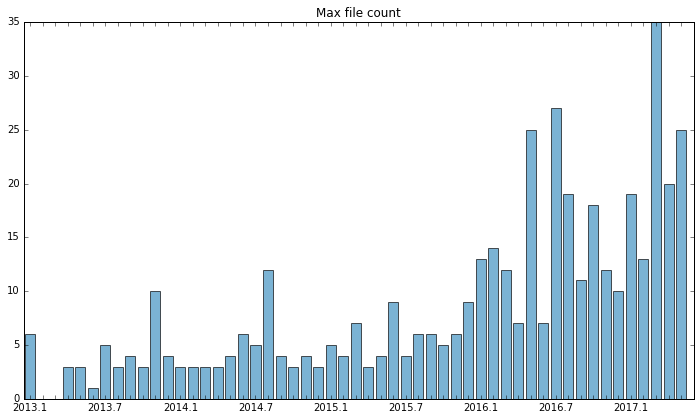

In [78]:
#pd.DataFrame(result).T['max'].plot('bar', color='blue',figsize=(16,9))

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(range(len(stat['max'])), stat['max'], color="#348ABD", alpha=0.65,
            label="#commits", align="center")
#plt.ylim([75,110])
plt.xticks(range(len(stat['max'])), stat['max'].index.map(lambda t: str(t[0]) + "." + str(t[1]) if t[1] % 6 == 1 else ""))
plt.xlim([-0.5, len(stat['max'])])
plt.title("Max file count")
plt.show()